In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from helper import *

import re
from typing import *

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


### Data Loading

In [2]:
# url = 'https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json'

In [2]:
save_path = Path("data/sarcasm/sarcasm.json")

In [3]:
# download_zip_file(url,save_path)

In [4]:
df = pd.read_json(save_path)

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
df['article_link'][0]

'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5'

In [8]:
def main_name(x):
    return re.findall(r'\.(.*?)\.', x)[0]

In [9]:
df['main_name'] = df['article_link'].apply(main_name)

In [10]:
df.head()

,article_link,headline,is_sarcastic,main_name
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [11]:
df['main_name'].value_counts(1)

huffingtonpost    0.561047
theonion          0.438953
Name: main_name, dtype: float64

In [12]:
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

In [13]:
sentences[:3], labels[:3]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild"],
 [0, 0, 1])

### 1.Cleaning the Data

In [19]:
def clean_data(sentences:List):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, len(sentences)):
        each_sentence = re.sub('[^a-zA-Z]', ' ', sentences[i])
        each_sentence = each_sentence.lower()
        each_sentence = each_sentence.split()

        each_sentence = [ps.stem(word)
                         for word in each_sentence if not word in stopwords.words('english')]
        each_sentence = ' '.join(each_sentence)
        corpus.append(each_sentence)
    return corpus

In [20]:
clean_sentences = clean_data(sentences)

In [21]:
clean_sentences[:3]

['former versac store clerk sue secret black code minor shopper',
 'roseann reviv catch thorni polit mood better wors',
 'mom start fear son web seri closest thing grandchild']

### 2.Train test Split

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    clean_sentences, labels, test_size=0.20, random_state=0, stratify=labels)

In [23]:
X_train[:3]

['share hazmat suit maker spike nyc ebola news',
 'miss america call u n council promot enough world peac',
 'tarsier world smallest primat anim planet looney front part']

In [24]:
pd.Series(y_train).value_counts(1)

0    0.561052
1    0.438948
dtype: float64

In [25]:
pd.Series(y_test).value_counts(1)

0    0.561026
1    0.438974
dtype: float64

### 3.TensorFlow Embeddings

In [26]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

In [28]:
X_train[:3]

['share hazmat suit maker spike nyc ebola news',
 'miss america call u n council promot enough world peac',
 'tarsier world smallest primat anim planet looney front part']

In [29]:
# Parameters for padding and OOV tokens
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [30]:
training_padded.shape

(21367, 50)

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (training_padded, training_labels))
train_dataset = (train_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

In [32]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (testing_padded, testing_labels))
test_dataset = (test_dataset
                .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                .batch(32)
                .prefetch(tf.data.AUTOTUNE))

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode='auto',
    # baseline=None,
    restore_best_weights=True,
    # start_from_epoch=0
)

In [38]:
def plot_dict(myDict):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(myDict['loss'])
    plt.plot(myDict['val_loss'])
    plt.subplot(1, 2, 2)
    plt.plot(myDict['accuracy'])
    plt.plot(myDict['val_accuracy'])
    plt.tight_layout()
    plt.show()

### With Dense & CONV 1D

In [76]:
# Build the model
filters = 128
kernel_size = 5

model = tf.keras.Sequential([

    tf.keras.layers.Embedding(

        vocab_size, embedding_dim, input_length=max_length,name="embedding"),
    
    tf.keras.layers.Conv1D(filters, kernel_size,padding='valid', activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(), 

    # tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),    
    tf.keras.layers.Dropout(0.3, name="dropout1"),    

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),

    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 conv1d_10 (Conv1D)          (None, 46, 128)           10368     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense32 (Dense)             (None, 32)                4128      
                                                                 
 batch1 (BatchNormalization)  (None, 32)               128       
                                                                 
 dropout1 (Dropout)          (None, 32)                0         
                                                      

In [77]:
# Compile the model
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00001),
              metrics=['accuracy'])

In [78]:
num_epochs = 30

# Train the model
history = model.fit(train_dataset, 
                    validation_data =test_dataset, 
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=[early_stopping])

668/668 - 6s - loss: 0.7490 - accuracy: 0.5795 - val_loss: 0.7142 - val_accuracy: 0.5674 - 6s/epoch - 9ms/step
Epoch 13/30
668/668 - 6s - loss: 0.7444 - accuracy: 0.5808 - val_loss: 0.7123 - val_accuracy: 0.5698 - 6s/epoch - 9ms/step
Epoch 14/30
668/668 - 6s - loss: 0.7373 - accuracy: 0.5858 - val_loss: 0.7091 - val_accuracy: 0.5715 - 6s/epoch - 9ms/step
Epoch 15/30
668/668 - 6s - loss: 0.7269 - accuracy: 0.5919 - val_loss: 0.7078 - val_accuracy: 0.5766 - 6s/epoch - 9ms/step
Epoch 16/30
668/668 - 7s - loss: 0.7267 - accuracy: 0.5928 - val_loss: 0.7050 - val_accuracy: 0.5792 - 7s/epoch - 10ms/step
Epoch 17/30
668/668 - 6s - loss: 0.7168 - accuracy: 0.6002 - val_loss: 0.7024 - val_accuracy: 0.5790 - 6s/epoch - 9ms/step
Epoch 18/30
668/668 - 6s - loss: 0.7016 - accuracy: 0.6097 - val_loss: 0.7009 - val_accuracy: 0.5790 - 6s/epoch - 9ms/step
Epoch 19/30
668/668 - 6s - loss: 0.6989 - accuracy: 0.6135 - val_loss: 0.6992 - val_accuracy: 0.5794 - 6s/epoch - 9ms/step
Epoch 20/30
668/668 - 6s - 

In [79]:
model.evaluate(testing_padded,testing_labels)

167/167 [==============================] - 1s 5ms/step - loss: 0.6739 - accuracy: 0.6174


[0.6739043593406677, 0.6173717975616455]

In [80]:
myDict = history.history

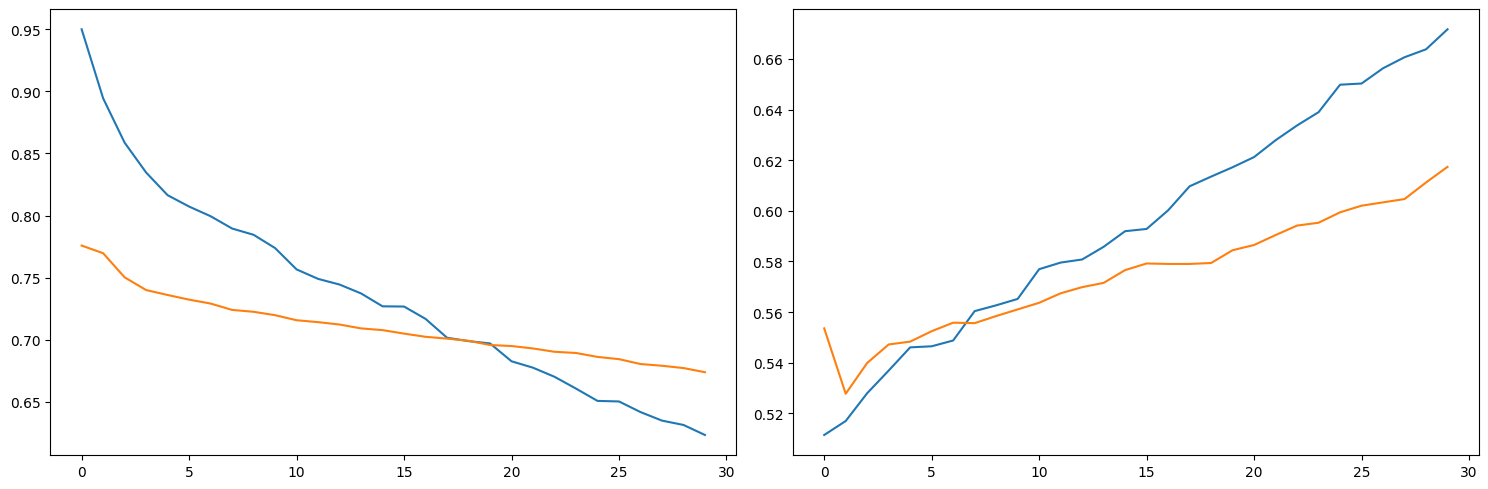

In [81]:
plot_dict(myDict)

### 4.GRU

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(3,input_shape=(40,3)),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 72        
                                                                 
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Sending input as 3 rows(each sentence) x 5 columns (embedding vector of each word)
# i have 3 RNN's with 5 vectors of each word weights = 5x3
print(model.get_weights()[0].shape)
model.get_weights()[0]

(3, 9)


array([[ 0.00698221,  0.48150665, -0.24228805,  0.18524837,  0.38073546,
        -0.15898716,  0.5191408 , -0.1553747 ,  0.5462535 ],
       [ 0.4624607 ,  0.14442712,  0.06200308,  0.12151188,  0.19565392,
         0.09923393, -0.67494756, -0.34716645, -0.06138349],
       [-0.41449857, -0.15467525,  0.46401352,  0.37507898,  0.04946357,
        -0.43800116,  0.21605217, -0.1549741 ,  0.6148121 ]],
      dtype=float32)

In [84]:
# If i use 3 RNN's means it has 3x3 matrix to hold each others input
# the connection between 5 vectors and 3 RNN cells holds 5x3 weights + 3x3 time weights
print(model.get_weights()[1].shape)
model.get_weights()[1]

(3, 9)


array([[-0.11785781, -0.29095802, -0.04321792,  0.38132676,  0.18667985,
        -0.20917755, -0.3375322 ,  0.37639368,  0.6480512 ],
       [-0.5639622 , -0.3917209 ,  0.05229671, -0.42308605,  0.49941558,
        -0.02339747, -0.02614227, -0.30983096, -0.01107621],
       [-0.15648174,  0.14914753, -0.59049004, -0.43190032, -0.37585354,
        -0.06836132, -0.51815194,  0.02749897,  0.05362184]],
      dtype=float32)

In [85]:
# Bias of 3 RNN cells
model.get_weights()[2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [86]:
# weights of RNN cell to dense which is 3
model.get_weights()[3]

array([[ 0.45874232, -0.7391418 , -0.7698612 , -0.14178824, -0.62287056],
       [-0.22869319, -0.15568435, -0.84453696, -0.7598467 , -0.20790535],
       [ 0.5692521 , -0.61033124, -0.24121022,  0.77203685,  0.26596946]],
      dtype=float32)

In [87]:
# bias of dense layer
model.get_weights()[4]

array([0., 0., 0., 0., 0.], dtype=float32)

### GRU on sequences

In [89]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(30, input_shape=(max_length, 1),return_sequences=False, name="GRU30"),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM30 (GRU)                (None, 30)                2970      
                                                                 
 dense32 (Dense)             (None, 32)                992       
                                                                 
 batch1 (BatchNormalization)  (None, 32)               128       
                                                                 
 dropout1 (Dropout)          (None, 32)                0         
                                                                 
 dense16 (Dense)             (None, 16)                528       
                                                                 
 batch2 (BatchNormalization)  (None, 16)               64        
                                                                 
 dropout2 (Dropout)          (None, 16)              

In [90]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [91]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks = [early_stopping])

Epoch 1/30
668/668 - 20s - loss: 0.6926 - binary_accuracy: 0.5550 - val_loss: 0.6930 - val_binary_accuracy: 0.5612 - 20s/epoch - 30ms/step
Epoch 2/30
668/668 - 13s - loss: 0.6915 - binary_accuracy: 0.5607 - val_loss: 0.6905 - val_binary_accuracy: 0.5610 - 13s/epoch - 19ms/step
Epoch 3/30
668/668 - 13s - loss: 0.6907 - binary_accuracy: 0.5611 - val_loss: 0.6905 - val_binary_accuracy: 0.5610 - 13s/epoch - 20ms/step
Epoch 4/30
668/668 - 14s - loss: 0.6898 - binary_accuracy: 0.5611 - val_loss: 0.6894 - val_binary_accuracy: 0.5610 - 14s/epoch - 22ms/step
Epoch 5/30
668/668 - 15s - loss: 0.6892 - binary_accuracy: 0.5611 - val_loss: 0.6893 - val_binary_accuracy: 0.5610 - 15s/epoch - 22ms/step
Epoch 6/30
668/668 - 14s - loss: 0.6886 - binary_accuracy: 0.5611 - val_loss: 0.6908 - val_binary_accuracy: 0.5610 - 14s/epoch - 20ms/step
Epoch 7/30
668/668 - 16s - loss: 0.6880 - binary_accuracy: 0.5611 - val_loss: 0.6872 - val_binary_accuracy: 0.5610 - 16s/epoch - 24ms/step
Epoch 8/30
668/668 - 18s - 

In [92]:
model.evaluate(test_dataset)

167/167 [==============================] - 1s 8ms/step - loss: 0.6705 - binary_accuracy: 0.5949


[0.6705204248428345, 0.5949082970619202]

### GRU with Embeddings

In [93]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length, name="embedding"),
    tf.keras.layers.GRU(30, name="GRU30", return_sequences=False),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 GRU30 (GRU)                 (None, 30)                4320      
                                                                 
 dense32 (Dense)             (None, 32)                992       
                                                                 
 batch1 (BatchNormalization)  (None, 32)               128       
                                                                 
 dropout1 (Dropout)          (None, 32)                0         
                                                                 
 dense16 (Dense)             (None, 16)                528       
                                                                 
 batch2 (BatchNormalization)  (None, 16)             

In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [95]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks=[early_stopping])

Epoch 1/30
668/668 - 24s - loss: 0.6927 - binary_accuracy: 0.5499 - val_loss: 0.6912 - val_binary_accuracy: 0.5610 - 24s/epoch - 36ms/step
Epoch 2/30
668/668 - 23s - loss: 0.6917 - binary_accuracy: 0.5608 - val_loss: 0.6915 - val_binary_accuracy: 0.5610 - 23s/epoch - 34ms/step
Epoch 3/30
668/668 - 18s - loss: 0.6909 - binary_accuracy: 0.5611 - val_loss: 0.6882 - val_binary_accuracy: 0.5610 - 18s/epoch - 27ms/step
Epoch 4/30
668/668 - 19s - loss: 0.6902 - binary_accuracy: 0.5611 - val_loss: 0.6857 - val_binary_accuracy: 0.5610 - 19s/epoch - 29ms/step
Epoch 5/30
668/668 - 17s - loss: 0.6895 - binary_accuracy: 0.5611 - val_loss: 0.6875 - val_binary_accuracy: 0.5610 - 17s/epoch - 26ms/step
Epoch 6/30
668/668 - 19s - loss: 0.6890 - binary_accuracy: 0.5611 - val_loss: 0.6895 - val_binary_accuracy: 0.5610 - 19s/epoch - 28ms/step
Epoch 7/30
668/668 - 17s - loss: 0.6886 - binary_accuracy: 0.5611 - val_loss: 0.6892 - val_binary_accuracy: 0.5610 - 17s/epoch - 26ms/step
Epoch 8/30
668/668 - 16s - 

### GRU Embeddings + Bideriectional

In [96]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length, name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
        50, name="GRU1_50", return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(
        50, name="GRU2_50", return_sequences=False)),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 100)          20400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              45600     
 nal)                                                            
                                                                 
 dense32 (Dense)             (None, 32)                3232      
                                                                 
 batch1 (BatchNormalization)  (None, 32)               128       
                                                                 
 dropout1 (Dropout)          (None, 32)              

In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [98]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks=[early_stopping])

Epoch 1/30
668/668 - 68s - loss: 0.8751 - binary_accuracy: 0.5143 - val_loss: 0.7028 - val_binary_accuracy: 0.5751 - 68s/epoch - 101ms/step
Epoch 2/30
668/668 - 51s - loss: 0.8139 - binary_accuracy: 0.5312 - val_loss: 0.6926 - val_binary_accuracy: 0.5704 - 51s/epoch - 76ms/step
Epoch 3/30
668/668 - 48s - loss: 0.7725 - binary_accuracy: 0.5347 - val_loss: 0.6842 - val_binary_accuracy: 0.5689 - 48s/epoch - 72ms/step
Epoch 4/30
668/668 - 48s - loss: 0.7485 - binary_accuracy: 0.5421 - val_loss: 0.6732 - val_binary_accuracy: 0.5824 - 48s/epoch - 72ms/step
Epoch 5/30
668/668 - 48s - loss: 0.7236 - binary_accuracy: 0.5574 - val_loss: 0.6693 - val_binary_accuracy: 0.5872 - 48s/epoch - 72ms/step
Epoch 6/30
668/668 - 47s - loss: 0.7101 - binary_accuracy: 0.5611 - val_loss: 0.6655 - val_binary_accuracy: 0.5960 - 47s/epoch - 70ms/step
Epoch 7/30
668/668 - 45s - loss: 0.6963 - binary_accuracy: 0.5716 - val_loss: 0.6609 - val_binary_accuracy: 0.6104 - 45s/epoch - 68ms/step
Epoch 8/30
668/668 - 44s -